# SHRED for Parametric MSFR-ULOFF: in-core moving probes
This notebook implements the SHRED architecture for generating a parametric Reduced Order Model (ROM) of the Molten Salt Fast Reactor (MSFR) during an accidental scenario named ULOFF (Unprotected Loss of Fuel Flow).

The pump failure scenario is a transient scenario where the pump stops working and the flow of fuel salt in the primary loop is interrupted, in particular the momentum source in the model decays exponentially following 
\begin{equation*}
f(t; \tau) = f_0 \exp\left(-\frac{t}{\tau}\right)
\end{equation*}

Different simulation data have been generated considering different values of the decay time $\tau \in [1, 10]$ with a physical time of 30 seconds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pickle

path_snaps = '../../NuSHRED_Datasets/D2/'
path_svd = './OfflineSVD/'
idx_params, params, var_names, is_vector, fom_times, rescaling_snaps, Nmodes = pickle.load(open(path_svd+'msfr_p.uloff', 'rb'))

## Compute Trajectories
The SHRED architecture can take as input 2 moving probes, advected by the fuel itself. Their coordinate over time can be mapped to the reduced space characterizing the MSFR-ULOFF scenario. 
Let $\mathbf{u}(\mathbf{x};t,\boldsymbol{\mu})$ be the velocity field of the fluid, where $\mathbf{x} \in \Omega$ is the spatial coordinate, $t$ is the time and $\boldsymbol{\mu}$ is the parameter vector. The trajectory of a moving probe is given by the ordinary differential equation
\begin{equation*}
\frac{d\mathbf{X}_m}{dt} = \mathbf{u}(\mathbf{X}_m; t, \boldsymbol{\mu}), \quad \mathbf{X}_m(0) = \mathbf{X}_{m,0}
\end{equation*}
where $\mathbf{X}_m(t)$ is the position of the $m$-th moving probe at time $t$ and $\mathbf{X}_{m,0}$ is the initial position.

Let us also extract the mesh nodes

[Text(1, 1.5, 'Configuration 1'),
 Text(1, 2.5, 'Configuration 2'),
 Text(1, 3.5, 'Configuration 3'),
 Text(1, 4.5, 'Configuration 4'),
 Text(1, 5.5, 'Configuration 5')]

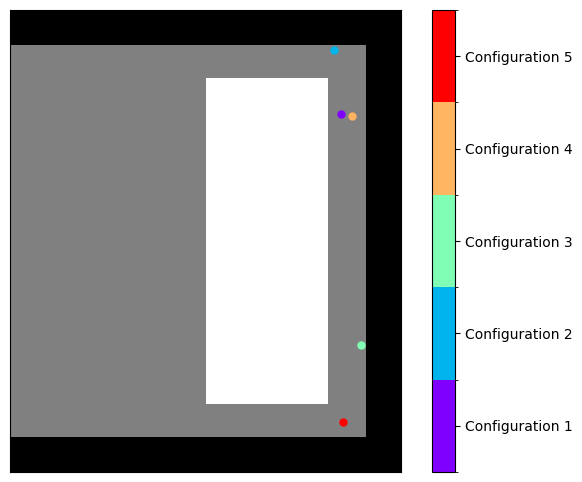

In [2]:
from plots import get_msfr_geometry
from matplotlib import colors as mcolors

nodes = pickle.load(open(path_snaps+'domain.pkl', 'rb'))

def is_out_core(node):
    return ((node[1] <= -1.11) or 
            (node[1] >=  1.11)) or (node[0] >= 2.03)
def is_downcomer(node):
    return ((node[1] >= -1.11) and 
            (node[1] <=  1.11)) and (node[0] >= 1.85 and node[0] <= 2.03)

downcomer = np.array([is_downcomer(node) for node in nodes])
downcomer_idx = np.where(downcomer)[0]

# Sampling the sensors locations
num_sensors_to_sample = 1

n_configurations = 5
idx_sensor_locations = np.zeros((num_sensors_to_sample, n_configurations), dtype=int)

np.random.seed(10) # set seed for reproducibility
for kk in range(n_configurations):
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(downcomer_idx, size=num_sensors_to_sample, replace=False), dtype=int)

# Plotting the sensors locations
import os
path_shred = './SHRED/MobileSensor/'
os.makedirs(path_shred, exist_ok=True)

fig, axs = plt.subplots(figsize=(8,6))
get_msfr_geometry(axs)

cmap = cm.rainbow
colors = cmap(np.linspace(0,1,n_configurations))
for kk in range(n_configurations):
    axs.scatter(nodes[idx_sensor_locations[:, kk], 0], nodes[idx_sensor_locations[:, kk], 1], 
                color = colors[kk], s=25, label=f'Configuration {kk+1}')

# Create a discrete colormap and normalization
bounds = np.linspace(1, n_configurations+1, n_configurations+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the discrete colorbar to the plot
midpoints = (bounds[:-1] + bounds[1:]) / 2
cbar = plt.colorbar(sm, ax=axs, ticks=np.arange(n_configurations + 1))
cbar.ax.set_yticks(midpoints)
cbar.ax.set_yticklabels([f'Configuration {i}' for i in np.hstack([np.array([1]), np.arange(2, n_configurations + 1, 1, dtype=int)])])

Let us build the different trajectories for the moving probes.

In [4]:
from tools import LagrangianTransport_msfr
from IPython.display import clear_output as clc

lagrangian = LagrangianTransport_msfr(nodes, path_snaps, times=fom_times, scaler = rescaling_snaps[0])

compute_trajectories = True

if compute_trajectories:

    sampling_mesh = 5
    time_idx = len(fom_times)-1

    vel_mag = list()
    trajectories = list()

    for param_i in range(len(params)):
        print('Trajectory for parameter #'+str(param_i+1))
        print(' ')
        vel_data = lagrangian.load_u_snapshots(param_i)

        trajectories.append(list())

        for kk in range(n_configurations):

            _x0 = np.stack([nodes[idx_sensor_locations[:, kk], 0], 
                            nodes[idx_sensor_locations[:, kk], 1]], axis=1).flatten()
            trajectories[param_i].append(lagrangian.calculate_trajectory(_x0, vel_data, 
                                                                         sampling_mesh = sampling_mesh, method = 'nearest').T)

        vel_mag.append(np.linalg.norm(vel_data, axis=0)[::sampling_mesh, time_idx])

        clc()

    _trajectories = np.asarray([np.asarray(traj).reshape(-1, vel_data.shape[2]).T for traj in trajectories])
    vel_mag = np.asarray(vel_mag)
    print('Trajectory calculations ended')
    pickle.dump([time_idx, _trajectories, vel_mag, sampling_mesh], open(path_shred+'trajectories_'+str(n_configurations)+'configs.pkl', 'wb'))
    # del vel_data # free memory
else:
    time_idx, _trajectories, vel_mag, sampling_mesh = pickle.load(open(path_shred+'trajectories_'+str(n_configurations)+'configs.pkl', 'rb'))

trajectories = _trajectories.reshape(_trajectories.shape[0], _trajectories.shape[1], n_configurations, -1)

Trajectory calculations ended


Let us make an example plot 

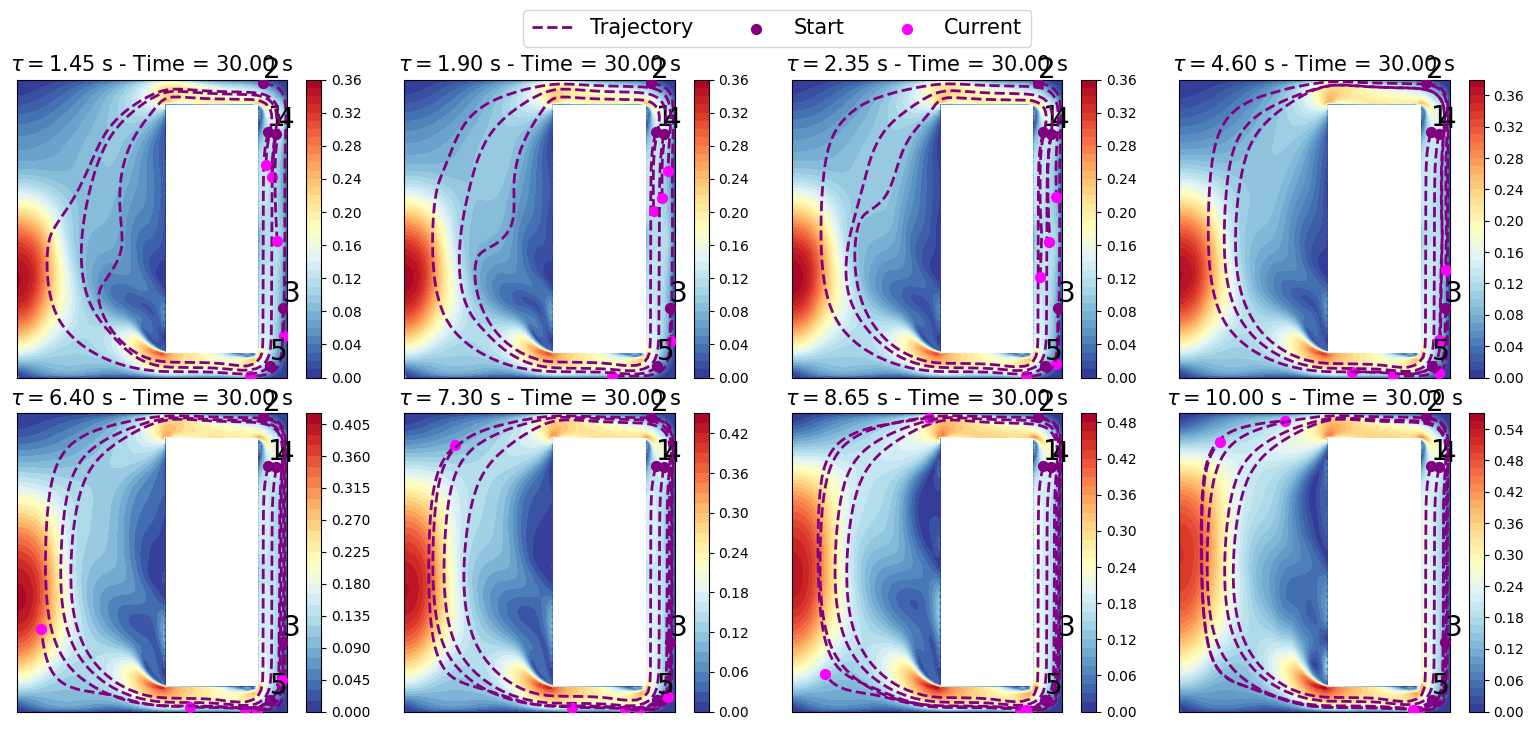

In [5]:
from plots import plot_trajectory

params_to_plot = np.sort(np.random.choice(len(trajectories), size=8, replace=False))

fig, axs = plt.subplots(2,4, figsize=(5 * 4, 4 * 2))
axs = axs.flatten()

for i, param_i in enumerate(params_to_plot):

    plot_trajectory(axs[i], lagrangian.nodes[::sampling_mesh], vel_mag[param_i], _trajectories[param_i], time_idx,
                    levels=40, plot_full_traj=True,
                    cmap = cm.RdYlBu_r)
        
    [axs[i].set_title(r'$\tau = {:.2f}$'.format(params[param_i][0])+' s - Time = {:.2f} s'.format(fom_times[time_idx]), fontsize=15) for jj in range(2)]

Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line[:3], Label[:3], loc='upper center', bbox_to_anchor=(0.525, 1), ncol=3, fontsize=15)

fig.subplots_adjust(top=0.9, wspace=0.00, hspace=0.12)

Let us transform the coordinates from cartesian to polar coordinates

$$
\begin{array}{l}
\rho &= \sqrt{x^2 + y^2}\\
\theta &= \arctan\left(\frac{y}{x}\right)
\end{array}
$$


In [6]:
def polar_to_cartesian(r, theta):
    return r*np.cos(theta), r*np.sin(theta)

def cartesian_to_polar(x, y):
    return np.sqrt(x**2 + y**2), np.arctan2(y, x)

polar_trajectories = np.zeros_like(trajectories)

for pp in range(len(trajectories)):
    for kk in range(n_configurations):
        x, y = polar_to_cartesian(trajectories[pp, :, kk, 0], trajectories[pp, :, kk, 1])
        polar_trajectories[pp, :, kk, 0] = x
        polar_trajectories[pp, :, kk, 1] = y

Now, we can import the field to measure through the mobile sensor

In [7]:
measured_field_i = 9

# Import Snaps - in compression format
u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{var_names[measured_field_i]}.svd', 'rb'))
s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{var_names[measured_field_i]}.svd', 'rb'))
vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[var_names[measured_field_i]]

measured_snaps = dict()
for key in idx_params.keys():
    measured_snaps[key] = np.asarray([ (u_data @ s_data @ vh_data[ii].T).T 
                                      for ii in idx_params[key]])

del u_data, s_data, vh_data # free memory

/var/folders/rq/_c546f811656mn_2__gt6l_00000gn/T/ipykernel_12622/3996435105.py:10: RuntimeWarning: divide by zero encountered in matmul
  measured_snaps[key] = np.asarray([ (u_data @ s_data @ vh_data[ii].T).T
/var/folders/rq/_c546f811656mn_2__gt6l_00000gn/T/ipykernel_12622/3996435105.py:10: RuntimeWarning: overflow encountered in matmul
  measured_snaps[key] = np.asarray([ (u_data @ s_data @ vh_data[ii].T).T
/var/folders/rq/_c546f811656mn_2__gt6l_00000gn/T/ipykernel_12622/3996435105.py:10: RuntimeWarning: invalid value encountered in matmul
  measured_snaps[key] = np.asarray([ (u_data @ s_data @ vh_data[ii].T).T


Let us now extract the sensor measures from the snapshots

In [8]:
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm

sens_measurements = list()

for kk in range(n_configurations):
    sens_measurements.append( dict() )
    for key in list(measured_snaps.keys()):
        sens_measurements[kk][key] = np.zeros((len(idx_params[key]), trajectories.shape[1], 2+1))

        bar = tqdm(range(len(idx_params[key])), desc=key+ ' - configuration #'+str(kk+1))

        for ii, mu in enumerate(idx_params[key]):

            _snap_evalutation_along_traj = np.zeros(trajectories.shape[1])

            for tt in range(trajectories.shape[1]):
                interpolant = NearestNDInterpolator(lagrangian.nodes[::sampling_mesh], measured_snaps[key][ii, tt, ::sampling_mesh].T)
                _snap_evalutation_along_traj[tt] = interpolant(trajectories[mu, tt, kk].T)[0]

            sens_measurements[kk][key][ii, :, 2] = _snap_evalutation_along_traj
            bar.update(1)

        bar.close()

        # sens_measurements[kk][key][:, :, :2] = trajectories[idx_params[key], :, kk, :]
        sens_measurements[kk][key][:, :, :2] = polar_trajectories[idx_params[key], :, kk, :]
    
    print('---------------------------------')
del measured_snaps

valid - configuration #1: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


---------------------------------


valid - configuration #2: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


---------------------------------


valid - configuration #3: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


---------------------------------


valid - configuration #4: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


---------------------------------


valid - configuration #5: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


---------------------------------


Let us add uncorrelated Gaussian noise to the measures

In [9]:
noise_value = 1e-2
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: sens_measurements[kk][key]
        for key in list(sens_measurements[kk].keys())
    })
    for key in list(sens_measurements[kk].keys()):
        # Xsensor[kk][key][:, :, -1] *= (1+np.random.normal(scale=noise_value, size=sens_measurements[kk][key][:, :, -1].shape))
        Xsensor[kk][key] *= (1+np.random.normal(scale=noise_value, size=sens_measurements[kk][key].shape))

print('Sensors Shape')
print(Xsensor[0]['train'].shape)
print(Xsensor[0]['test'].shape)
print(Xsensor[0]['valid'].shape)

Sensors Shape
(15, 600, 3)
(3, 600, 3)
(3, 600, 3)


Let us scale them to be in the range $[0, 1]$

In [10]:
from sklearn.preprocessing import MinMaxScaler

num_sensors = Xsensor[0]['train'].shape[2]

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

Let us plot the sensor output

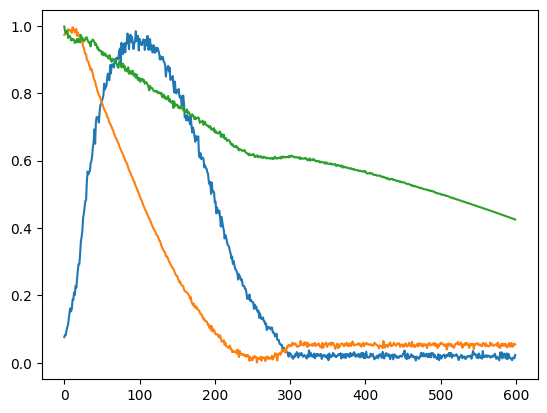

In [11]:
plt.plot(rescaled_Xsensor[1]['train'][8, :, :])

## Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [12]:
import pickle

v_POD = pickle.load(open(path_svd+'v_POD.svd', 'rb'))

assert sum(Nmodes) == v_POD['train'].shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(v_POD[key].reshape(-1, sum(Nmodes))).reshape(v_POD[key].shape)
    for key in list(v_POD.keys())
}

Let us create the parameters data

In [13]:
mu = np.zeros((params.shape[0], len(fom_times), params.shape[1]))
for idx in range(params.shape[0]):
    mu[idx] = params[idx]

parameters = {
    key : mu[idx_params[key]]
    for key in list(idx_params.keys())
}

Nparams = params.shape[1]
param_scaler = MinMaxScaler()
param_scaler.fit(parameters['train'].reshape(-1, Nparams))

rescaled_parameters = {
    key: param_scaler.transform(parameters[key].reshape(-1, Nparams)).reshape(parameters[key].shape)
    for key in list(parameters.keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)

print('POD Coeff Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

Params Shape
(15, 600, 1)
(3, 600, 1)
(3, 600, 1)
POD Coeff Shape
(15, 600, 220)
(3, 600, 220)
(3, 600, 220)


Then, let us prepare them for the SHRED architecture

In [14]:
import sys
sys.path.append('../../')

from shred.processdata import Padding, TimeSeriesDataset
import torch

device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

lags = 50

# Input Data
train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags).to(device) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags).to(device) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags).to(device)  for kk in range(n_configurations)]

# Output Data
train_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['train']), 
                                     torch.from_numpy(rescaled_parameters['train'])), 
                                     axis=2), 1).squeeze(1).to(device)

valid_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['valid']), 
                                     torch.from_numpy(rescaled_parameters['valid'])), 
                                     axis=2), 1).squeeze(1).to(device)

test_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['test']), 
                                     torch.from_numpy(rescaled_parameters['test'])), 
                                     axis=2), 1).squeeze(1).to(device)

output_size = sum(Nmodes) + Nparams

# Create Dataset for SHRED training
train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk],  test_data_out)  for kk in range(n_configurations)]

## SHRED
Let us train the SHRED models for each configuration

In [17]:
from shred.models import SHRED, fit
import os

train_net = True

shred = list()
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))

    if train_net:
        print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 50)

        shred[kk].freeze()
        torch.save(shred[kk].state_dict(),   path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors/2)+'probes.shred')
        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors/2)+'probes.shred',
                                             map_location=device))
        shred[kk].freeze()
    

Training SHRED - configuration 1/5
Training done: Training loss = 3.25% 	 Validation loss = 3.84%      
 
Training SHRED - configuration 2/5
Training done: Training loss = 3.77% 	 Validation loss = 3.80%      
 
Training SHRED - configuration 3/5
Training done: Training loss = 8.51% 	 Validation loss = 17.08%      
 
Training SHRED - configuration 4/5
Training done: Training loss = 2.85% 	 Validation loss = 3.05%      
 
Training SHRED - configuration 5/5
Training done: Training loss = 2.36% 	 Validation loss = 2.74%      
 


Checking the test errors on the POD coefficients

In [18]:
path_test = './Test_results/MobileSensor/'
os.makedirs(path_test, exist_ok=True)
pickle.dump(test_dataset, open(path_test+'test_dataset.pkl', 'wb'))

from shred.processdata import num2p, mre

Ytest_POD_hat = torch.stack([shred[kk](test_data_in[kk]) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0) / np.sqrt(n_configurations),
    'cov': torch.stack([torch.cov(Ytest_POD_hat[:, i, :sum(Nmodes)].T) for i in range(Ytest_POD_hat.shape[1])]) / n_configurations
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out,
                                                                            Ytest_POD_pred['mean'])))
print("Std  relative SHRED prediction error on POD coeffs: %s." % num2p((Ytest_POD_pred['std'].pow(2).sum(axis = -1).sqrt() / (test_data_out).pow(2).sum(axis = -1).sqrt()).mean()))

Mean relative SHRED prediction error on POD coeffs: 5.44%.
Std  relative SHRED prediction error on POD coeffs: 3.79%.


Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [19]:
reshaped_test_out = test_data_out.cpu().detach().numpy().reshape(len(idx_params['test']), len(fom_times), sum(Nmodes) + Nparams)

reshaped_POD_test_out = {
    'mean': Ytest_POD_pred['mean'].cpu().detach().numpy().reshape(len(idx_params['test']), len(fom_times), sum(Nmodes) + Nparams),
    'std':  Ytest_POD_pred['std'].cpu().detach().numpy().reshape(len(idx_params['test']), len(fom_times), sum(Nmodes) + Nparams),
    'cov': Ytest_POD_pred['cov'][:, :sum(Nmodes), :sum(Nmodes)].cpu().detach().numpy().reshape(len(idx_params['test']), len(fom_times), sum(Nmodes), sum(Nmodes)),
    'full': Ytest_POD_hat[:, :, :sum(Nmodes)].cpu().detach().numpy().reshape(n_configurations, len(idx_params['test']), len(fom_times), sum(Nmodes))
}

Let us define the variables in LaTeX format for plotting

In [20]:
tex_var_names = [r'\mathbf{u}', 'T', '\Phi']
energy_groups = 6
tex_var_names.extend([r'\phi_'+str(g+1) for g in range(energy_groups)])

prec_groups = 8
tex_var_names.extend([r'c_'+str(g+1) for g in range(prec_groups)])

tex_var_names.extend(['p', r'p_{\text{rgh}}', r'\kappa', r'\nu_t', "q'''"])

assert len(tex_var_names) == len(var_names)

Let us plot the error for each output of the SHRED

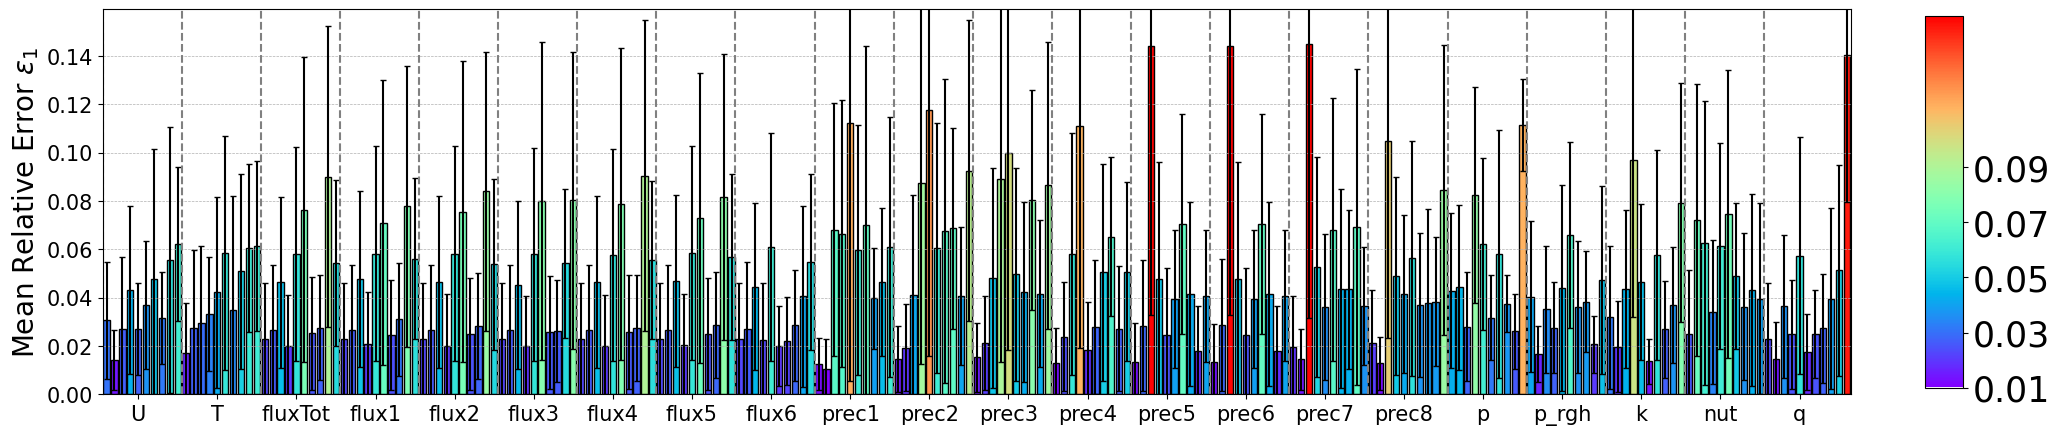

In [21]:
from matplotlib.colors import Normalize

# errors_pod_coeffs already computed
errors_pod_coeffs = [np.mean(np.abs(reshaped_test_out[:, :, pp] - reshaped_POD_test_out['mean'][:, :, pp]), axis=(0,1)) / np.mean(np.abs(reshaped_test_out[:, :, pp]))
                     for pp in range(reshaped_test_out.shape[2])]
err_std_pod_coeffs = [np.mean(reshaped_POD_test_out['std'][:, :, pp], axis=(0,1)) / np.mean(np.abs(reshaped_test_out[:, :, pp]))
                     for pp in range(reshaped_test_out.shape[2])]

fig, axs = plt.subplots(1, 1, figsize=(24, 5))

# Normalize error values to [0,1] for colormap mapping
norm = Normalize(vmin=min(errors_pod_coeffs), vmax=max(errors_pod_coeffs))
cmap = cm.rainbow  # choose your favorite colormap here
colors = cmap(norm(errors_pod_coeffs))

# Plot bars with colors
bars = axs.bar(np.arange(sum(Nmodes)+Nparams), errors_pod_coeffs, 
               yerr = err_std_pod_coeffs, ecolor='k', capsize=2,
               edgecolor='k',
               color=colors)

# Vertical lines for Nmodes grouping
for pp in range(len(Nmodes)):
    axs.axvline(x=np.cumsum(Nmodes)[pp]-Nmodes[0]-0.5, color='gray', linestyle='--')

axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_ylabel(r'Mean Relative Error $\varepsilon_1$', fontsize=20)

# Add x-ticks for modes grouping
xticks = []
xtick_labels = []
for pp in range(len(Nmodes)):
    xticks.append(np.cumsum(Nmodes)[pp]-Nmodes[0]/2-1)
    xtick_labels.append(f'{var_names[pp]}')
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=0, fontsize=15)

axs.grid(which='both', axis='y', linestyle='--', linewidth=0.5)
axs.set_xlim(-0.5, sum(Nmodes)+Nparams-0.5)
axs.set_ylim(0, max(errors_pod_coeffs)*1.1)

# Add colorbar for reference
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, fraction=0.02, pad=0.04, aspect=10)
cbar.ax.tick_params(labelsize=25)
# cbar.ax.set_ylabel('Error value', fontsize=30)
cbar.ax.set_yticks(np.arange(0.01, 0.11, 0.02))

Comparison plots of the POD coefficients

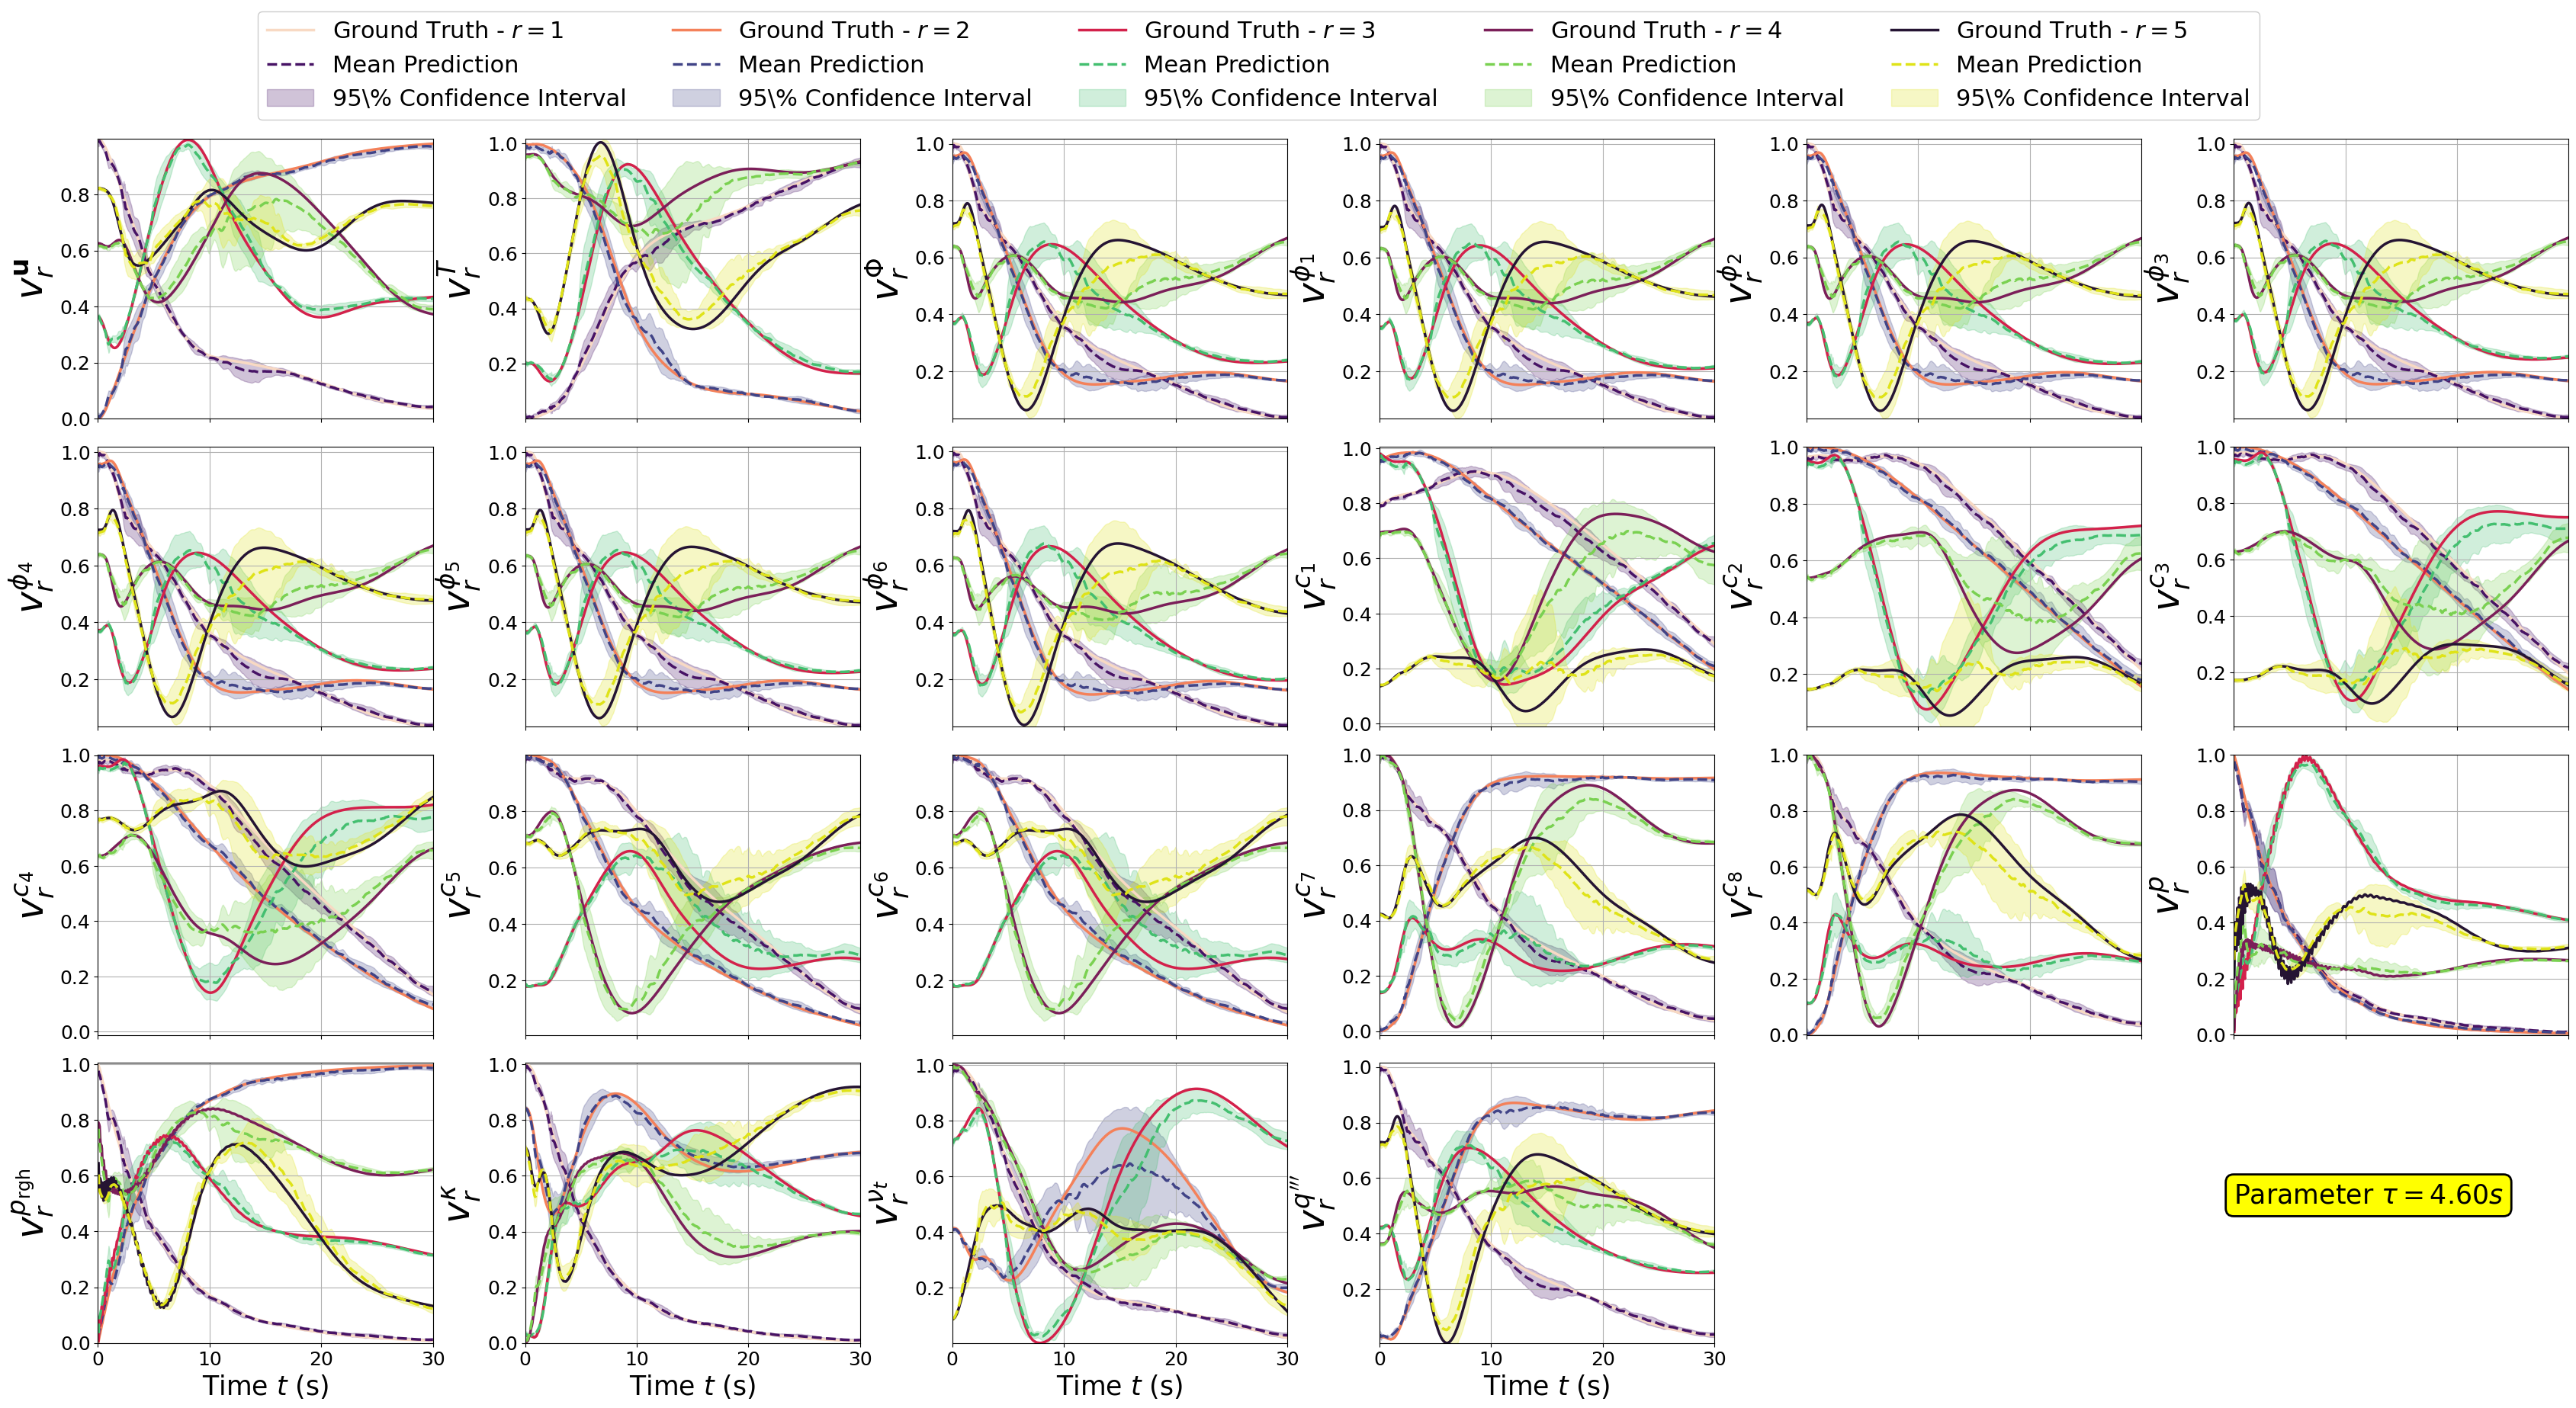

In [22]:
modes_to_plot = 5
param_to_plot = 0

nrows = 4
ncols = 6
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize=(6 * ncols, 5 * nrows))
axs = axs.flatten()

ls = 2.5

for field_i, field in enumerate(var_names):

    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    colors = cm.viridis([0.05, 0.2, 0.7, 0.8, 0.95])
    colors_gt = sns.color_palette("rocket", as_cmap=True)(np.linspace(0.1,0.95,len(idx_to_plot)))
    for ii, idx in enumerate(idx_to_plot):
        axs[field_i].plot(fom_times, reshaped_test_out[param_to_plot,:,idx],
                          '-', linewidth=ls, c=colors_gt[-1-ii], label=r'Ground Truth - $r='+str(ii+1)+'$')
        axs[field_i].plot(fom_times, reshaped_POD_test_out['mean'][param_to_plot,:,idx],
                          '--', c=colors[ii], label=r'Mean Prediction', linewidth=ls)
        axs[field_i].fill_between(fom_times,
                                    y1 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    y2 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    color=colors[ii], alpha=0.25, label=r'95\% Confidence Interval')

    axs[field_i].set_ylabel(r'$v_r^{'+tex_var_names[field_i]+r'}$', fontsize=35)
    axs[field_i].grid()

    axs[field_i].set_ylim(reshaped_test_out[:,:,idx_to_plot].min(), 
                          reshaped_test_out[:,:,idx_to_plot].max())
    axs[field_i].set_xlim(0, fom_times[-1])
    axs[field_i].tick_params(axis='both', labelsize=18)

for field_i in range(len(var_names), nrows * ncols):
    axs[field_i].axis('off')

Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=22, ncols=5, framealpha=1, loc=(0.1, 0.915))

axs = axs.reshape(nrows, ncols)
axs[-1, -1].annotate(   r'Parameter $\tau = {:.2f} s$'.format(params[idx_params['test'][param_to_plot],0]), 
                        xy=(0., .5), xycoords='axes fraction', fontsize=25,
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', lw=2))

[ax.set_xlabel(r'Time $t$ (s)', fontsize=25) for ax in axs[-1]]

fig.subplots_adjust(left=0, hspace=0.1, top = 0.9, wspace=0.275)
fig.savefig(path_test+'SHRED_dynamics_uq.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compare the POD coefficients for the different values of $\tau$ for selected fields

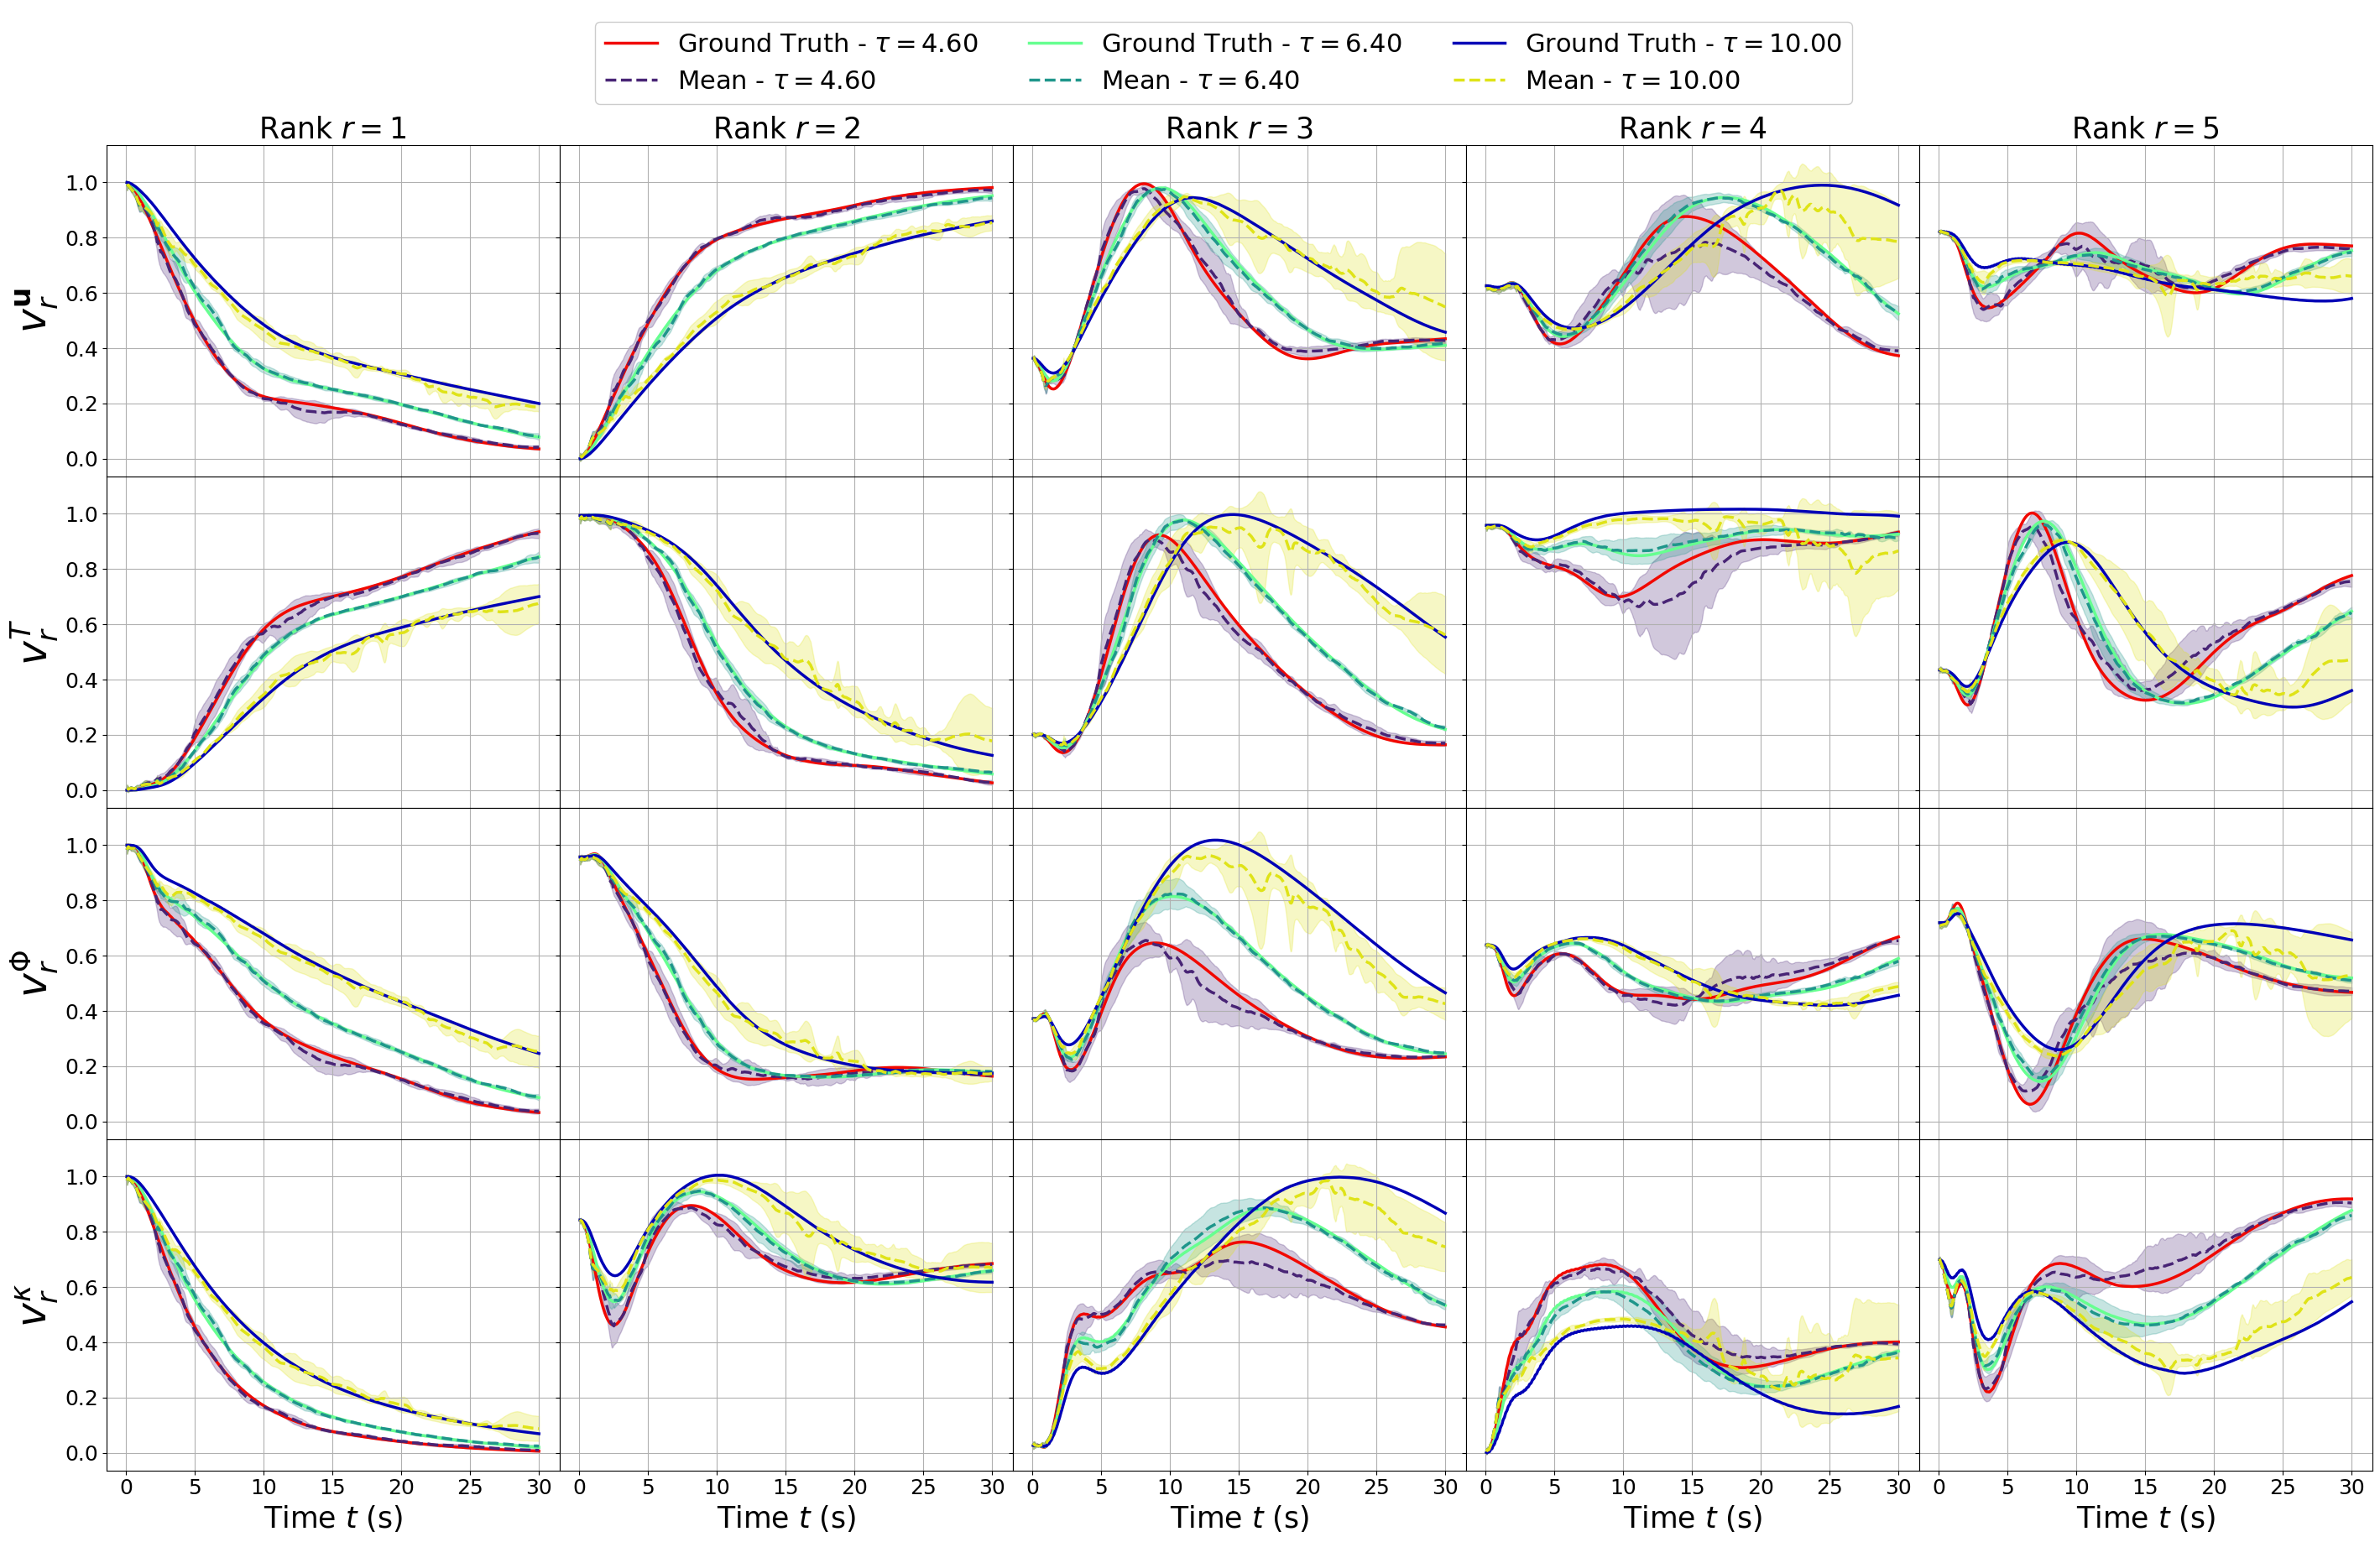

In [23]:
fields_idx_to_plot = [0,1,2,19]

nrows = len(fields_idx_to_plot)
ncols = modes_to_plot

fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(6 * ncols, 5 * nrows))

ls = 2.5

for ii, field_i in enumerate(fields_idx_to_plot):
    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    colors = cm.viridis(np.linspace(0.1,0.95,len(idx_params['test'])))
    colors_gt = cm.jet_r(np.linspace(0.1,0.95,len(idx_params['test'])))

    for jj, idx in enumerate(idx_to_plot):
        for param_to_plot in range(len(idx_params['test'])):
            axs[ii, jj].plot(fom_times, reshaped_test_out[param_to_plot,:,idx],
                            '-', linewidth=ls, c=colors_gt[param_to_plot], label=r'Ground Truth - $\tau = {:.2f}'.format(params[idx_params['test'][param_to_plot],0])+'$')
            axs[ii, jj].plot(fom_times, reshaped_POD_test_out['mean'][param_to_plot,:,idx],
                                '--', c=colors[param_to_plot], label=r'Mean - $\tau = {:.2f}'.format(params[idx_params['test'][param_to_plot],0])+'$', linewidth=ls)
            axs[ii, jj].fill_between(fom_times,
                                    y1 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    y2 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    color=colors[param_to_plot], alpha=0.25)
        axs[ii,jj].grid()
        axs[ii,jj].tick_params(axis='both', labelsize=18)
    
[axs[0, jj].set_title(r'Rank $r='+str(jj+1)+'$', fontsize=25) for jj in range(ncols)]
[axs[ii, 0].set_ylabel(r'$v_r^{'+tex_var_names[fields_idx_to_plot[ii]]+r'}$', fontsize=35) for ii in range(nrows)]
[axs[-1, jj].set_xlabel(r'Time $t$ (s)', fontsize=25) for jj in range(ncols)]

Line, Label = axs[0,0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=22, ncols=3, framealpha=1, loc=(0.25, 0.9325))

fig.subplots_adjust(left=0, hspace=0.0, top = 0.9, wspace=0.)
fig.savefig(path_test+'SHRED_dynamics_test_parameters.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Decoding to High-Dimensional Space
Let us decode the output of the SHRED models to the high-dimensional space.

The error is computed using the Euclidian norm

In [25]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from IPython.display import clear_output as clc

if train_net:
    ave_rel_errors = {
        'mean': np.zeros((len(var_names), len(idx_params['test']), len(fom_times))),
        'std' : np.zeros((len(var_names), len(idx_params['test']), len(fom_times)))
    }

    for field_i in range(len(var_names)):
        field = var_names[field_i]
        idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

        # Load compressed dataset
        u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{field}.svd', 'rb'))
        s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{field}.svd', 'rb'))
        vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[field]

        for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
            fom = u_data @ s_data @ vh_data[idx_params['test'][param_to_recon]].T

        u_svd = pickle.load(open(path_svd+'pod_basis_'+field+'.svd', 'rb'))
        s_svd = pickle.load(open(path_svd+'sing_vals_'+field+'.svd', 'rb'))

        # Scale the components of the v-coefficients to the original range
        # _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'][:,:,:-1].shape)
        # _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'][:,:,:-1].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'][:,:,:-1].shape) - vpod_scaler.data_min_
        _tmp_v = {
            'mean': vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape[0], reshaped_POD_test_out['mean'].shape[1], sum(Nmodes)),
            'std':  vpod_scaler.inverse_transform(reshaped_POD_test_out['std'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape[0], reshaped_POD_test_out['mean'].shape[1], sum(Nmodes)) - vpod_scaler.data_min_,
            'full': np.array([vpod_scaler.inverse_transform(reshaped_POD_test_out['full'][kk].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape[0], reshaped_POD_test_out['mean'].shape[1], sum(Nmodes)) for kk in range(n_configurations)])
        }
        _tmp_v['cov'] = np.zeros((reshaped_POD_test_out['cov'].shape[0],
                                  reshaped_POD_test_out['cov'].shape[1],
                                  reshaped_POD_test_out['cov'].shape[2]-Nparams,
                                  reshaped_POD_test_out['cov'].shape[3]-Nparams))
        for _ii in range(_tmp_v['cov'].shape[0]):
            for _tt in range(_tmp_v['cov'].shape[1]):
                _tmp_v['cov'][_ii, _tt] = np.diag(vpod_scaler.data_max_[:-1]-vpod_scaler.data_min_[:-1]) @ reshaped_POD_test_out['cov'][_ii, _tt, :-1, :-1] @ np.diag(vpod_scaler.data_max_[:-1]-vpod_scaler.data_min_[:-1]).T
        
        # Go back to the high-dimensional space
        recon     = u_svd @ np.diag(s_svd) @ _tmp_v['mean'][param_to_recon, :, idx_to_rec]
        std_recon = np.zeros_like(recon)
        for kk in range(n_configurations):
            std_recon +=  (u_svd @ np.diag(s_svd) @ _tmp_v['full'][kk][param_to_recon, :, idx_to_rec] - recon) ** 2 / (n_configurations - 1)
        std_recon = np.sqrt(std_recon) / np.sqrt(n_configurations)

        ave_rel_errors['mean'][field_i, param_to_recon] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, param_to_recon]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

        del fom, recon, std_recon
    del u_data, s_data, vh_data
    clc()

Let us plot the errors using bar plots

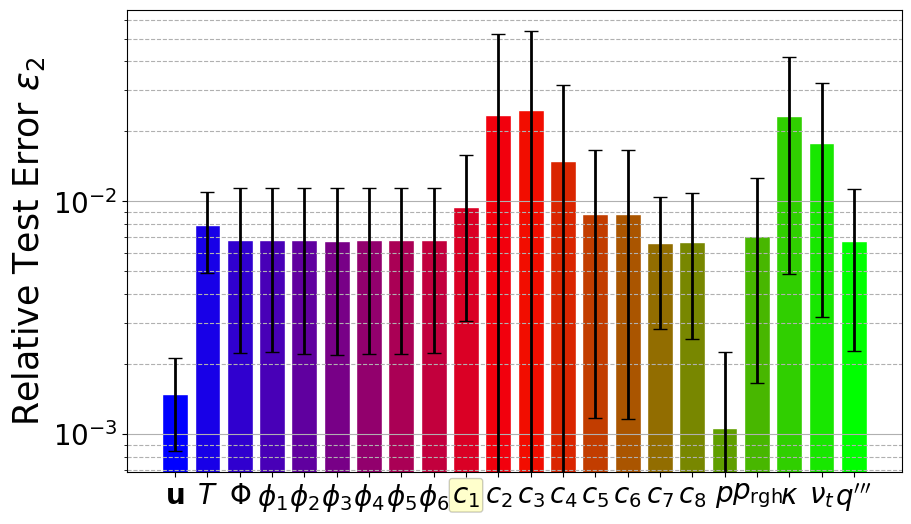

In [26]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,6))

colors = cm.brg(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), ave_rel_errors['mean'].mean(axis=2).mean(axis=1), 
        yerr = ave_rel_errors['mean'].mean(axis=1).std(axis=1), capsize=5,
        color = colors,
        edgecolor='white',error_kw={'elinewidth': 2, 'ecolor': 'black', 'capsize': 5})

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

# Highlight the tick label at xtick = 4
xticks = axs.get_xticklabels()
xticks[measured_field_i].set_color('black')  # Adjust index 3 (Python indexing starts at 0)
# Add a box around tick label at xtick = 3
xticks[measured_field_i].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.2))

fig.savefig(path_test+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compute also some average quantities

In [27]:
vars_to_compare = [1,3,9,19]

fom_average = dict()
shred_average = dict()
shred_std = dict()

def get_average(u, s, vh):
    _ave = np.zeros((len(u), vh[0].shape[1]))

    for pp in range(len(u)):
        _ave_modes = np.mean(u[pp], axis=0).reshape(1,-1)
        _ave[pp] = np.linalg.multi_dot([_ave_modes, np.diag(s[pp]), vh[pp]])
    return _ave

for ii in range(len(vars_to_compare)):
    field = var_names[vars_to_compare[ii]]

    # FOM
    u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{field}.svd', 'rb'))
    s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{field}.svd', 'rb'))
    vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[field]

    fom_average[field] = np.zeros((len(idx_params['test']), len(fom_times)))
    for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        fom = u_data @ s_data @ vh_data[idx_params['test'][param_to_recon]].T
        fom_average[field][param_to_recon] = np.mean(rescaling_snaps[vars_to_compare[ii]].inverse_transform(fom), axis=0)

    # SHRED
    idx_to_rec = np.arange(sum(Nmodes[:vars_to_compare[ii]]),  sum(Nmodes[:vars_to_compare[ii]+1]),  1, dtype=int)

    u_svd = pickle.load(open(path_svd+'pod_basis_'+field+'.svd', 'rb'))
    s_svd = pickle.load(open(path_svd+'sing_vals_'+field+'.svd', 'rb'))

    _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'][:,:,:-1].shape)
    # _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'][:,:,:-1].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'][:,:,:-1].shape) - vpod_scaler.data_min_
    _tmp_full_v = np.array([vpod_scaler.inverse_transform(reshaped_POD_test_out['full'][kk].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape[0], reshaped_POD_test_out['mean'].shape[1], sum(Nmodes)) for kk in range(n_configurations)])

    shred_average[field] = np.zeros((len(idx_params['test']), len(fom_times)))
    shred_std[field]     = np.zeros((len(idx_params['test']), len(fom_times)))

    for pp in range(len(idx_params['test'])):
        
        # Mean reconstruction
        recon = rescaling_snaps[vars_to_compare[ii]].inverse_transform(
            u_svd @ np.diag(s_svd) @ _tmp_mean_v[pp, :, idx_to_rec]
        )

        shred_average[field][pp] = np.mean(recon, axis=0)

        # Std reconstruction
        std_recon = np.zeros((u_svd.shape[0], len(fom_times)))
        for kk in range(n_configurations):
            std_recon +=  (rescaling_snaps[vars_to_compare[ii]].inverse_transform(u_svd @ np.diag(s_svd) @ _tmp_full_v[kk][pp, :, idx_to_rec]) - recon) ** 2 / (n_configurations - 1)
        std_recon = np.sqrt(std_recon) / np.sqrt(n_configurations)

        shred_std[field][pp] = np.mean(std_recon, axis=0)

    del u_data, s_data, vh_data, u_svd, s_svd


Computing error for k: 100%|██████████| 3/3 [00:00<00:00, 10.82it/s]


Now let us plot them

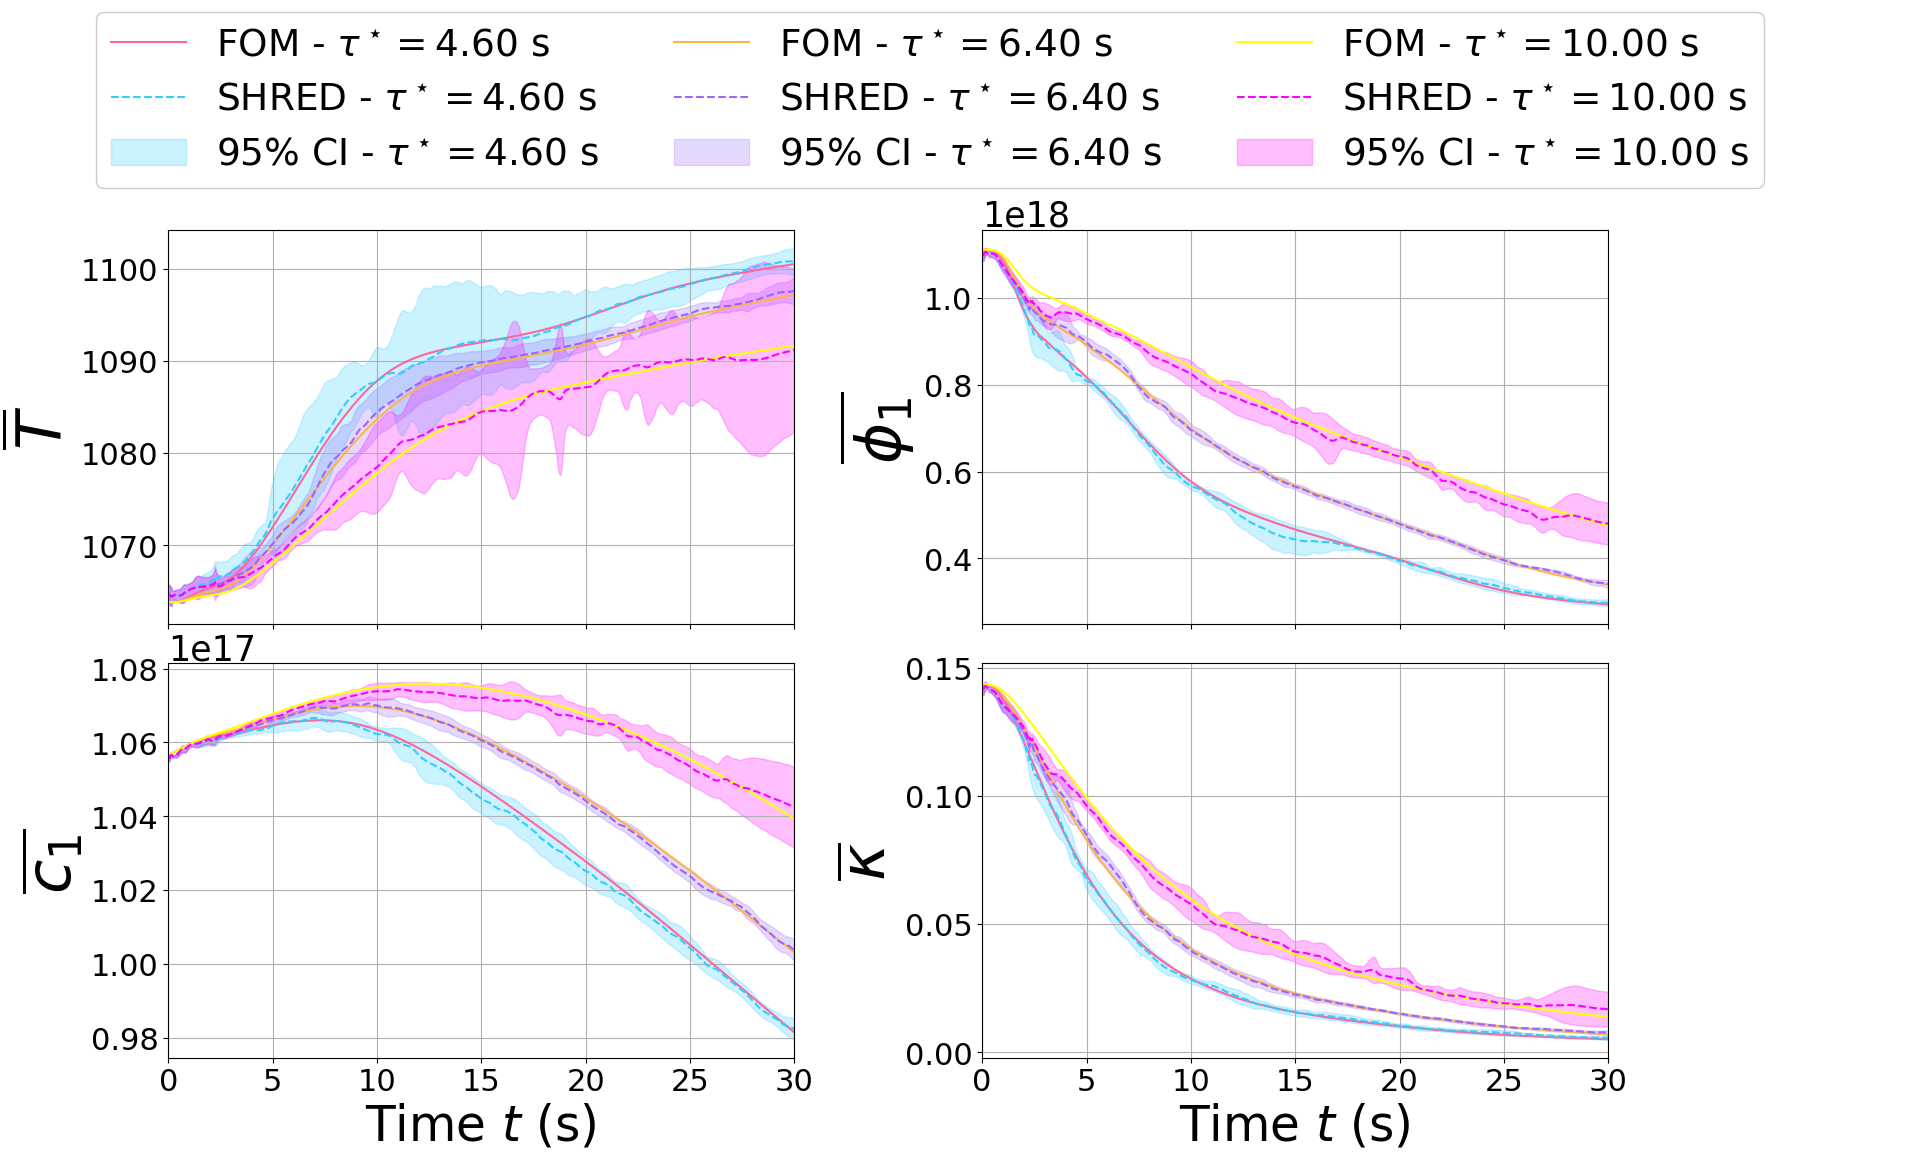

In [28]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, 
                        figsize=(8 * 2, 6 * 2))
axs = axs.flatten()

colors = cm.spring(np.linspace(0.4, 1, len(idx_params['test'])))
colors_shred = cm.cool(np.linspace(0.2, 1, len(idx_params['test'])))

for ii in range(len(vars_to_compare)):
    field = var_names[vars_to_compare[ii]]

    for pp in range(len(idx_params['test'])):
        axs[ii].plot(fom_times, fom_average[field][pp], label=r'FOM - $\tau^\star = {:.2f}$ s'.format(params[idx_params['test'][pp],0]), color=colors[pp])
        axs[ii].plot(fom_times, shred_average[field][pp], '--', label=r'SHRED - $\tau^\star = {:.2f}$ s'.format(params[idx_params['test'][pp],0]), color=colors_shred[pp])
        axs[ii].fill_between(fom_times,
                                    y1 = shred_average[field][pp] - 1.96 * shred_std[field][pp],
                                    y2 = shred_average[field][pp] + 1.96 * shred_std[field][pp],
                                    color=colors_shred[pp], alpha=0.25,
                                    label=r'95% CI - $\tau^\star = {:.2f}$ s'.format(params[idx_params['test'][pp],0]))

    axs[ii].set_xlim(0, fom_times[-1])
    axs[ii].set_ylabel(r"$\overline{{"+tex_var_names[vars_to_compare[ii]]+r"}}$", fontsize=45)
    if ii >= 2:
        axs[ii].set_xlabel(r'Time $t$ (s)', fontsize=35)
    # axs[ii].set_xlabel(r'Time $t$ (s)', fontsize=35)

    axs[ii].grid()
    axs[ii].tick_params(axis='both', labelsize=22)
    axs[ii].set_xticks([0, 5, 10, 15, 20, 25, 30])

    # Increase the size of the scientific notation multiplier (e.g., x10^15)
    axs[ii].yaxis.get_offset_text().set_fontsize(25)  # Adjust this value as needed

Line, Label = axs[0].get_legend_handles_labels()

fig.legend(Line, Label, fontsize=27, ncols=3, framealpha=1, loc=(0.05, 0.8375))
fig.subplots_adjust(left=0, wspace=0.3, top = 0.8, hspace=0.1)
fig.savefig(path_test+'fom_shred_QoIcomparison.pdf', format='pdf', dpi=150, bbox_inches='tight')


### Contour Plots
In the end, some contour plots are shown to visualize the reconstruction in the high-dimensional space.

In [29]:
from plots import plot_contour, create_streamlines

cmaps = [
    cm.RdYlBu_r,
    sns.color_palette("icefire", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.color_palette("mako", as_cmap=True),
    sns.color_palette("mako", as_cmap=True),
    sns.color_palette("Blues", as_cmap=True),
    sns.color_palette("YlOrBr", as_cmap=True),
    cm.jet,
]

Let us select the field and the parameter to plot

In [40]:
field_i = 9 # 0, 1, 3, 9
field = var_names[field_i]
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

param_to_plot = 0

u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{field}.svd', 'rb'))
s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{field}.svd', 'rb'))
vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[field]

fom = rescaling_snaps[field_i].inverse_transform(u_data @ s_data @ vh_data[idx_params['test'][param_to_plot]].T)

Let us reconstruct the field

In [41]:
u_svd = pickle.load(open(path_svd+'pod_basis_'+field+'.svd', 'rb'))
s_svd = pickle.load(open(path_svd+'sing_vals_'+field+'.svd', 'rb'))

_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'][:,:,:-1].shape)
# _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'][:,:,:-1].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'][:,:,:-1].shape) - vpod_scaler.data_min_
_tmp_full_v = np.array([vpod_scaler.inverse_transform(reshaped_POD_test_out['full'][kk].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape[0], reshaped_POD_test_out['mean'].shape[1], sum(Nmodes)) for kk in range(n_configurations)])

recon = rescaling_snaps[field_i].inverse_transform(
    u_svd @ np.diag(s_svd) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]
)

std_recon = np.zeros((u_svd.shape[0], len(fom_times)))
for kk in range(n_configurations):
    std_recon +=  (rescaling_snaps[field_i].inverse_transform(u_svd @ np.diag(s_svd) @ _tmp_full_v[kk][param_to_plot, :, idx_to_rec]) - recon) ** 2 / (n_configurations - 1)
std_recon = np.sqrt(std_recon) / np.sqrt(n_configurations)

Here, the plots for videos are generated

In [160]:
import matplotlib.ticker as mticker
        
path_fig = path_test+'Figs/Param_{:.2f}'.format(params[idx_params['test'][param_to_plot],0])+'/'+field+'/'
os.makedirs(path_fig, exist_ok=True)

vec_mode_to_plot = 'Mag' if field_i == 0 else None
streamline_plot = True if field_i == 0 else False

# Add titles
if vec_mode_to_plot is not None:
    _var = r'$\|'+tex_var_names[field_i]+'\|_2$'
else:
    _var = r'$'+tex_var_names[field_i]+'$'

ncols = 2

resid = np.abs(fom - recon)

for time_to_plot in tqdm(np.arange(19, len(fom_times), 20)):

    vec_mode_to_plot = 'Mag' if field_i == 0 else None
    streamline_plot = True if field_i == 0 else False

    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4), dpi=250)
    levels = np.linspace(0,1.5,100) if vec_mode_to_plot is not None else np.linspace(fom.min(), fom.max(), 200)

    # FOM plot
    fom_contour = plot_contour(axs[0], nodes, fom[:, time_to_plot], cmap=cmaps[field_i],
                               streamline_plot = streamline_plot,
                            vec_mode_to_plot=vec_mode_to_plot, levels=levels)

    # Reconstruction plot
    recon_contour = plot_contour(axs[1], nodes, recon[:, time_to_plot], cmap=cmaps[field_i],
                               streamline_plot = streamline_plot,
                                vec_mode_to_plot=vec_mode_to_plot, levels=levels)

    # Residual plot
    if ncols > 2:
        resid_contour = plot_contour(axs[2], nodes, resid[:, time_to_plot],
                                    vec_mode_to_plot=vec_mode_to_plot, cmap=cm.hot, levels=30)
        cbar_res = fig.colorbar(resid_contour,
                                ax=axs[2], orientation='vertical', pad=0.05, aspect=20, shrink = 0.75)
        cbar_res.ax.tick_params(labelsize=12)

        cbar_res.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        axs[2].set_title(r'Residual - '+_var, fontsize=20)

    fig.subplots_adjust(wspace=0.05)

    # Add colorbars
    cbar_fom = fig.colorbar(fom_contour, 
                            ax=axs[:2], orientation='horizontal', pad=0.05, aspect=20, shrink = 0.85)
    cbar_fom.ax.tick_params(labelsize=10)
  
    # cbar_fom.ax.set_yticks(np.linspace(levels[0], levels[-1], 10))

    # Add titles
    if vec_mode_to_plot is not None:
        _var = r'$\|'+tex_var_names[field_i]+'\|_2$'
    else:
        _var = r'$'+tex_var_names[field_i]+'$'

    axs[0].set_title(r'FOM - '+_var, fontsize=20)
    axs[1].set_title(r'SHRED - '+_var, fontsize=20)

    if ncols > 2:
        axs[-1].annotate(    r'Time $t={:.2f}$'.format(fom_times[time_to_plot])+r's - Parameter $\tau = {:.2f} s$'.format(params[idx_params['test'][param_to_plot],0]),
                            xy=(-0.15, -0.1), xycoords='axes fraction', fontsize=15, color='black',
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', lw=2))
    else:
        axs[-1].annotate(    r'Time $t={:.2f}$'.format(fom_times[time_to_plot])+r's',
                            xy=(-0.5, 1.1), xycoords='axes fraction', fontsize=10, color='black',
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', lw=2))

    fig.savefig(path_fig+'FOM_vs_SHRED_{:.2f}'.format(fom_times[time_to_plot])+'.png', 
                format='png', dpi=250, bbox_inches='tight', transparent=False)
    plt.close(fig)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)
100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


Make gifs

In [ ]:
import imageio.v2 as imageio

# Create the GIF by loading each image and adding it to the array
def get_gif(gif_path, image_files, duration=150.):
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for img_file in image_files:
            img_path = os.path.join(path_fig, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

# Create the MP4 video by loading each image and adding it to the array
def get_video(video_path, image_files, fps=10):
    with imageio.get_writer(video_path, fps=fps, codec="libx264") as writer:
        for img_file in image_files:
            img_path = os.path.join(path_fig, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

image_files = sorted(os.listdir(path_fig), key=lambda x: int(x.split('_')[-1].split('.')[0]))

get_gif(path_test+'Figs/Param_{:.2f}/'.format(params[idx_params['test'][param_to_plot],0])+var_names[field_i]+'.gif', image_files, duration=200.)
get_video(path_test+'Figs/Param_{:.2f}/'.format(params[idx_params['test'][param_to_plot],0])+var_names[field_i]+'.mp4', image_files, fps=5)

os.makedirs('../../media/P2/', exist_ok=True)
os.system('mv '+path_test+'Figs/Param_{:.2f}/'.format(params[idx_params['test'][param_to_plot],0])+var_names[field_i]+'.gif ../../media/P2/'+var_names[field_i]+'_mobile_sens.gif')

Let us make a plot of the standard deviation, similar to the paper version

In [42]:
time_to_plot = len(fom_times) - 1
    
vec_mode_to_plot = 'Mag' if field_i == 0 else None
streamline_plot = True if field_i == 0 else False

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=250)
levels = np.linspace(0,0.4,100) if vec_mode_to_plot is not None else np.linspace(fom[:, time_to_plot].min(), fom[:, time_to_plot].max()*1.01, 200)

# FOM plot
fom_contour = plot_contour(axs[0], nodes, fom[:, time_to_plot], cmap=cmaps[field_i],
                            streamline_plot = streamline_plot,
                            vec_mode_to_plot=vec_mode_to_plot, levels=levels)

# Reconstruction plot
recon_contour = plot_contour(axs[1], nodes, recon[:, time_to_plot], cmap=cmaps[field_i],
                            streamline_plot = streamline_plot,
                            vec_mode_to_plot=vec_mode_to_plot, levels=levels)

# # Residual plot
# resid_contour = plot_contour(axs[2], domain_plot, np.abs(fom - recon)[:, time_to_plot],
#                             vec_mode_to_plot=vec_mode_to_plot, cmap=cm.hot, levels=20)

# Std-Deviation plot
resid_contour = plot_contour(axs[2], nodes, std_recon[:, time_to_plot],
                            streamline_plot = streamline_plot,
                            vec_mode_to_plot=vec_mode_to_plot, cmap=cm.hot, levels=200)

fig.subplots_adjust(wspace=0.05)

# Add colorbars
cbar_fom = fig.colorbar(fom_contour, 
                        ax=axs[:2], orientation='horizontal', pad=0.05, aspect=40, shrink = 0.85)
cbar_fom.ax.tick_params(labelsize=12)
# cbar_fom.ax.set_xticks([0,0.1, 0.2, 0.3, 0.4]) # U
# cbar_fom.ax.set_xticks(np.arange(900, 1301, 50)) # T

cbar_res = fig.colorbar(resid_contour,
                        ax=axs[2], orientation='vertical', pad=0.05, aspect=20, shrink = 0.75)
cbar_res.ax.tick_params(labelsize=12)

# Add titles
if vec_mode_to_plot is not None:
    _var = r'$\|'+tex_var_names[field_i]+'\|_2$'
else:
    _var = r'$'+tex_var_names[field_i]+'$'

axs[0].set_title(r'FOM - '+_var, fontsize=20)
axs[1].set_title(r'SHRED - '+_var, fontsize=20)
# axs[2].set_title(r'Residual - '+_var, fontsize=20)
axs[2].set_title(r'Standard Dev - '+_var, fontsize=20)

axs[2].annotate(    r'Time $t={:.2f}$'.format(fom_times[time_to_plot])+r's - Parameter $\tau = {:.2f} s$'.format(params[idx_params['test'][param_to_plot],0]),
                    xy=(-0.15, -0.1), xycoords='axes fraction', fontsize=15,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', lw=2))

fig.subplots_adjust(wspace=0., bottom = 0.25)

fig.savefig(path_test+field+'_FOM_vs_SHRED_{:.2f}'.format(fom_times[time_to_plot])+'.png', 
            format='png', dpi=250, bbox_inches='tight')
plt.close(fig)